# 1. 준비

Runtime Type = Python 3
Hardware Accelerator = GPU

그 다음에 환경 세팅

#모델에 필요한 파일 받기

In [1]:
#현재 위치 확인
!pwd

/content


In [2]:
#ACGPN 모델 파일 다운로드
!git clone https://github.com/kairess/ACGPN.git

Cloning into 'ACGPN'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 165 (delta 21), reused 19 (delta 18), pack-reused 141
Receiving objects: 100% (165/165), 303.15 KiB | 13.18 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [3]:
#다운로드 받은 파일의 위치로 이동
%cd ACGPN

/content/ACGPN


#dependencies 및 사전 파일 준비

In [4]:
!pip install -U --no-cache-dir gdown --pre -qq
!pip install ninja -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 8.4 MB/s eta 0:00:00


In [5]:
import gdown
import numpy as np
from PIL import Image
import IPython
import os
import sys
import time

from predict_pose import generate_pose_keypoints

In [6]:
#모델을 돌리기 위한 파일 준비
!mkdir Data_preprocessing/test_color
!mkdir Data_preprocessing/test_colormask
!mkdir Data_preprocessing/test_edge
!mkdir Data_preprocessing/test_img
!mkdir Data_preprocessing/test_label
!mkdir Data_preprocessing/test_mask
!mkdir Data_preprocessing/test_pose
!mkdir inputs
!mkdir inputs/img
!mkdir inputs/cloth

In [7]:
#현재 위치 확인
!pwd

/content/ACGPN


In [8]:
#휴먼 세그멘테이션 모델 파일 다운로드
!git clone https://github.com/levindabhi/Self-Correction-Human-Parsing-for-ACGPN.git
#옷 마스킹 모델 파일 다운로드
!git clone https://github.com/levindabhi/U-2-Net.git

Cloning into 'Self-Correction-Human-Parsing-for-ACGPN'...
remote: Enumerating objects: 769, done.
remote: Counting objects: 100% (769/769), done.
remote: Compressing objects: 100% (583/583), done.
remote: Total 769 (delta 184), reused 661 (delta 175), pack-reused 0
Receiving objects: 100% (769/769), 3.89 MiB | 6.06 MiB/s, done.
Resolving deltas: 100% (184/184), done.
Cloning into 'U-2-Net'...
remote: Enumerating objects: 822, done.
remote: Counting objects: 100% (327/327), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 822 (delta 308), reused 298 (delta 298), pack-reused 495
Receiving objects: 100% (822/822), 30.71 MiB | 10.45 MiB/s, done.
Resolving deltas: 100% (389/389), done.


#사전학습 모델 다운로드

## 포즈 예측 모델

In [9]:
!gdown --id 11dRA_iLSJFFsOWXuadmH7Apqukc2F_Vf -O pose/pose_iter_440000.caffemodel

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=11dRA_iLSJFFsOWXuadmH7Apqukc2F_Vf
From (redirected): https://drive.google.com/uc?id=11dRA_iLSJFFsOWXuadmH7Apqukc2F_Vf&confirm=t&uuid=3070adbe-397a-4c55-abc5-65f31e677af3
To: /content/ACGPN/pose/pose_iter_440000.caffemodel
100% 209M/209M [00:04<00:00, 44.5MB/s]


## 휴먼 세그멘테이션 모델

In [10]:
gdown.download('https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH', 'lip_final.pth', quiet=False)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH
From (redirected): https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH&confirm=t&uuid=bb0dfa2b-defb-4d9b-8986-517e802b5974
To: /content/ACGPN/lip_final.pth
100%|██████████| 267M/267M [00:09<00:00, 27.1MB/s]


'lip_final.pth'

## U-2-Net모델 (옷 마스크 추출 모델)

In [11]:
#U-2-Net 모델을 돌릴 때 필요한 파일 준비를 위해 해당 모델 파일로 이동
%cd U-2-Net

#U-2-Net 모델에 필요한 파일 생성
!mkdir saved_models
!mkdir saved_models/u2net
!mkdir saved_models/u2netp

#사전 학습된 U-2-Net 모델 다운로드
!gdown 1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy -O saved_models/u2netp/u2netp.pth
!gdown 1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ -O saved_models/u2net/u2net.pth

import u2net_load
import u2net_run

#로드하려면 쿠다 필요 (위치 확인용)
u2net = u2net_load.model(model_name='u2netp')

#U-2-Net 모델을 위한 파일 준비가 끝나면 부모 파일로 이동
%cd ..

/content/ACGPN/U-2-Net
mkdir: cannot create directory ‘saved_models’: File exists
Downloading...
From: https://drive.google.com/uc?id=1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy
To: /content/ACGPN/U-2-Net/saved_models/u2netp/u2netp.pth
100% 4.68M/4.68M [00:00<00:00, 36.0MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ
From (redirected): https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ&confirm=t&uuid=7ebb0e86-1600-4177-a6e0-231fb4c67b28
To: /content/ACGPN/U-2-Net/saved_models/u2net/u2net.pth
100% 176M/176M [00:02<00:00, 62.3MB/s]
...load U2NEP---4.7 MB
/content/ACGPN


## ACGPN모델 (사진 합성 모델)

In [12]:
#ACGPN 모델에 필요한 파일 생성
!mkdir checkpoints

#사전 학습된 ACGPN 모델 다운로드
gdown.download('https://drive.google.com/uc?id=1UWT6esQIU_d4tUm8cjxDKMhB8joQbrFx', output='checkpoints/ACGPN_checkpoints.zip', quiet=False)

#압축된 모델 파일 풀어서 전에 만든 파일위치에 넣어줌
!unzip checkpoints/ACGPN_checkpoints.zip -d checkpoints

Downloading...
From (uriginal): https://drive.google.com/uc?id=1UWT6esQIU_d4tUm8cjxDKMhB8joQbrFx
From (redirected): https://drive.google.com/uc?id=1UWT6esQIU_d4tUm8cjxDKMhB8joQbrFx&confirm=t&uuid=f33feeef-337d-48d4-bf96-bd8eeda21091
To: /content/ACGPN/checkpoints/ACGPN_checkpoints.zip
100%|██████████| 524M/524M [00:08<00:00, 59.0MB/s]


Archive:  checkpoints/ACGPN_checkpoints.zip
   creating: checkpoints/label2city/
  inflating: checkpoints/label2city/latest_net_G.pth  
  inflating: checkpoints/label2city/latest_net_G1.pth  
  inflating: checkpoints/label2city/latest_net_G2.pth  
  inflating: checkpoints/label2city/latest_net_U.pth  
  inflating: checkpoints/label2city/opt.txt  


In [13]:
!pwd
%cd ..
!pwd

/content/ACGPN
/content
/content


이제 업스케일링 폴더 구조 공부해서 만들어야 함..

In [14]:
# Clone Real-ESRGAN and enter the Real-ESRGAN
!git clone https://github.com/xinntao/Real-ESRGAN.git
%cd Real-ESRGAN
# Set up the environment
!pip install basicsr
!pip install facexlib
!pip install gfpgan
!pip install -r requirements.txt
!python setup.py develop

Cloning into 'Real-ESRGAN'...
remote: Enumerating objects: 755, done.
remote: Total 755 (delta 0), reused 0 (delta 0), pack-reused 755
Receiving objects: 100% (755/755), 5.37 MiB | 11.21 MiB/s, done.
Resolving deltas: 100% (410/410), done.
/content/Real-ESRGAN
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 27.8 MB/s eta 0:00:00
  Created wheel for basicsr: filename=basicsr-1.4.2-py3-none-any.whl size=214824 sha256=1b4bf3b08fdeaa001d361ef3ac6904a4dea61723b85e237c1721911db2e27e9d
  Stored in directory: /root/.cache/pip/wheels/38/83/99/2d8437cc652a01af27df5ff037a4075e95b52d67705c5f30ca
Successfully built basicsr
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 5.2 MB/s eta 0:00:00
     ━━━━

In [15]:
!pwd

/content/Real-ESRGAN


업스케일링 폴더 생성

In [17]:
import os
from google.colab import files
import shutil

upload_folder = 'upload'
result_folder = 'results'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
if os.path.isdir(result_folder):
    shutil.rmtree(result_folder)
os.mkdir(upload_folder)
os.mkdir(result_folder)

ACGPN 돌리고 -> 업스케일링 폴더로 이동시키기 -> 업스케일링 진행 후 이미지 반환!

In [18]:
%cd ..
%cd ACGPN

/content
/content/ACGPN


In [20]:
#옷 데이터셋이 올바른 위치에 있는지 확인
sorted(os.listdir('inputs/cloth'))

['000048_1.jpg']

Generating mask for: cloth_1689573800.png
Saving output at Data_preprocessing/test_edge/cloth_1689573800.png


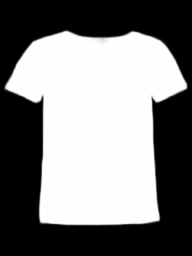

In [21]:
#전처리 할 옷 데이터 이름을 시간으로 지정
cloth_name = f'cloth_{int(time.time())}.png'

#전처리 할 옷 데이터의 파일 위치 확인
cloth_path = os.path.join('inputs/cloth', sorted(os.listdir('inputs/cloth'))[0])

#이미지 할당
cloth = Image.open(cloth_path)

#이미지 사이즈 조절 및 RGB모드로 변환
cloth = cloth.resize((192, 256), Image.BICUBIC).convert('RGB')

#전처리를 위해 옷 이미지 파일을 해당 파일 위치에 지정해준 옷 데이터 이름으로 저장
cloth.save(os.path.join('Data_preprocessing/test_color', cloth_name))

#전처리를 위해 U-2-Net모델을 지정한 파일 위치에서 데이터셋을 가저와서 돌리고, 지정한 위치에 전처리 된 옷 이미지 파일을 저장
u2net_run.infer(u2net, 'Data_preprocessing/test_color', 'Data_preprocessing/test_edge')

#결과 확인을 위해 전처리 된 옷 이미지 파일을 열어봄
Image.open(f'Data_preprocessing/test_edge/{cloth_name}')

In [22]:
#모델 데이터셋이 올바른 위치에 있는지 확인
sorted(os.listdir('inputs/img'))

['000001_0.jpg']

In [23]:
#전처리 할 모델 데이터 이름을 시간으로 지정
img_name = f'img_{int(time.time())}.png'

#전처리 할 모델 데이터의 파일 위치 확인
img_path = os.path.join('inputs/img', sorted(os.listdir('inputs/img'))[0])

#이미지 할당
img = Image.open(img_path)

#이미지 사이즈 조절
img = img.resize((192,256), Image.BICUBIC)

#전처리를 위해 모델 이미지 파일의 위치값을 해당 파일 위치에 지정해준 모델 데이터 이름으로 지정
img_path = os.path.join('Data_preprocessing/test_img', img_name)

#지정해준 모델 이미지 파일의 위치값을 바탕으로 이미지 저장
img.save(img_path)

#전처리를 위해 휴먼 세그멘테이션 모델을 parser를 이용하여 돌림 ***parser는 데이터셋의 종류, 사전학습 모델 파일의 위치, 전처리 할 모델 이미지 위치, 전처리 후 이미지 저장할 위치
!python3 Self-Correction-Human-Parsing-for-ACGPN/simple_extractor.py --dataset 'lip' --model-restore 'lip_final.pth' --input-dir 'Data_preprocessing/test_img' --output-dir 'Data_preprocessing/test_label'

#모델 포즈 예측 모델을 돌리고 저장할 파일 위치와 파일 이름 형식을 지정
pose_path = os.path.join('Data_preprocessing/test_pose', img_name.replace('.png', '_keypoints.json'))

#모델 포즈 예측 모델을 전처리 할 모델 이미지 위치, 전처리 후 파일 위치를 받아서 돌리고 저장
generate_pose_keypoints(img_path, pose_path)


100% 1/1 [00:00<00:00,  1.85it/s]
File saved at Data_preprocessing/test_pose/img_1689573812_keypoints.json


In [24]:
#기존에 존재하던 test_pairs.txt파일을 삭제 후 이번에 돌릴 이미지 이름들로 고쳐서 생성 *** 기존 test_pairs.txt파일에는 input으로 넣어준 옷 이미지 모델 이름과, 모델 이미지 이름이 존재
!rm -rf Data_preprocessing/test_pairs.txt
with open('Data_preprocessing/test_pairs.txt', 'w') as f:
    f.write(f'{img_name} {cloth_name}')

In [25]:
#ACGPN 추론 실행
!python test.py

?
------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
continue_train: False
data_type: 32
datapairs: test_pairs.txt
dataroot: Data_preprocessing/
display_winsize: 512
engine: None
export_onnx: None
fineSize: 512
gpu_ids: [0]
how_many: 1000
input_nc: 3
isTrain: False
label_nc: 20
loadSize: 512
max_dataset_size: inf
model: pix2pixHD
nThreads: 1
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_local_enhancers: 1
name: label2city
netG: global
ngf: 64
niter_fix_global: 0
no_flip: False
norm: instance
ntest: inf
onnx: None
output_nc: 3
phase: test
resize_or_crop: scale_width
results_dir: ./results/
serial_batches: True
tf_log: False
use_dropout: False
use_encoded_image: False
verbose: False
which_epoch: latest
-------------- End ----------------
CustomDatasetDataLoader
dataset [AlignedDataset] was created
Data_preprocessing/test_label label
Data_preprocessing/test_img img
Data_preprocessing/tes

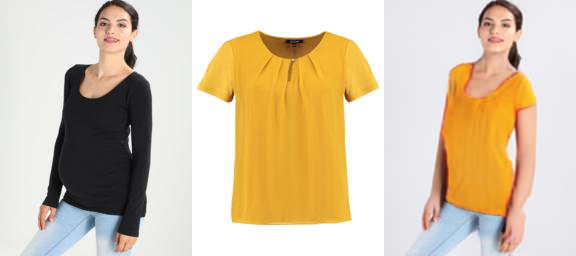

In [26]:
output_grid = np.concatenate([
    np.array(Image.open(f'Data_preprocessing/test_img/{img_name}')),
    np.array(Image.open(f'Data_preprocessing/test_color/{cloth_name}')),
    np.array(Image.open(f'results/test/try-on/{img_name}'))
], axis=1)

image_grid = Image.fromarray(output_grid)

image_grid

In [27]:
!pwd
%cd ..

/content/ACGPN
/content


In [28]:
from PIL import Image
from pathlib import Path
import os

CURRENT_DIR = Path()
q = CURRENT_DIR / 'Real-ESRGAN' / 'upload'
d = CURRENT_DIR / 'ACGPN' / 'results' / 'test' / 'try-on' / f"{img_name}"


file_path = f"/ACGPN/results/test/try-on/{img_name}"

# 이미지 파일을 변수에 로드
uploaded = Image.open(d)

print(uploaded)



# 변수에 로드된 이미지 파일을 원하는 폴더로 이동
filename = os.path.basename(file_path)
dst_path = os.path.join(upload_folder, filename)
print(f'move {filename} to {dst_path}')


print('이게 dst = ' + dst_path)

shutil.move(d, q)



<PIL.PngImagePlugin.PngImageFile image mode=RGB size=192x256 at 0x7D2502A28D30>
move img_1689573812.png to upload/img_1689573812.png
이게 dst = upload/img_1689573812.png


'Real-ESRGAN/upload/img_1689573812.png'

In [29]:
!pwd
%cd Real-ESRGAN

/content
/content/Real-ESRGAN


In [30]:
# if it is out of memory, try to use the `--tile` option
# We upsample the image with the scale factor X3.5
!python inference_realesrgan.py -n RealESRGAN_x4plus -i upload --outscale 3.5 --face_enhance
# Arguments
# -n, --model_name: Model names
# -i, --input: input folder or image
# --outscale: Output scale, can be arbitrary scale factore.

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
Downloading: "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth" to /content/Real-ESRGAN/weights/RealESRGAN_x4plus.pth

100% 63.9M/63.9M [00:00<00:00, 355MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current b

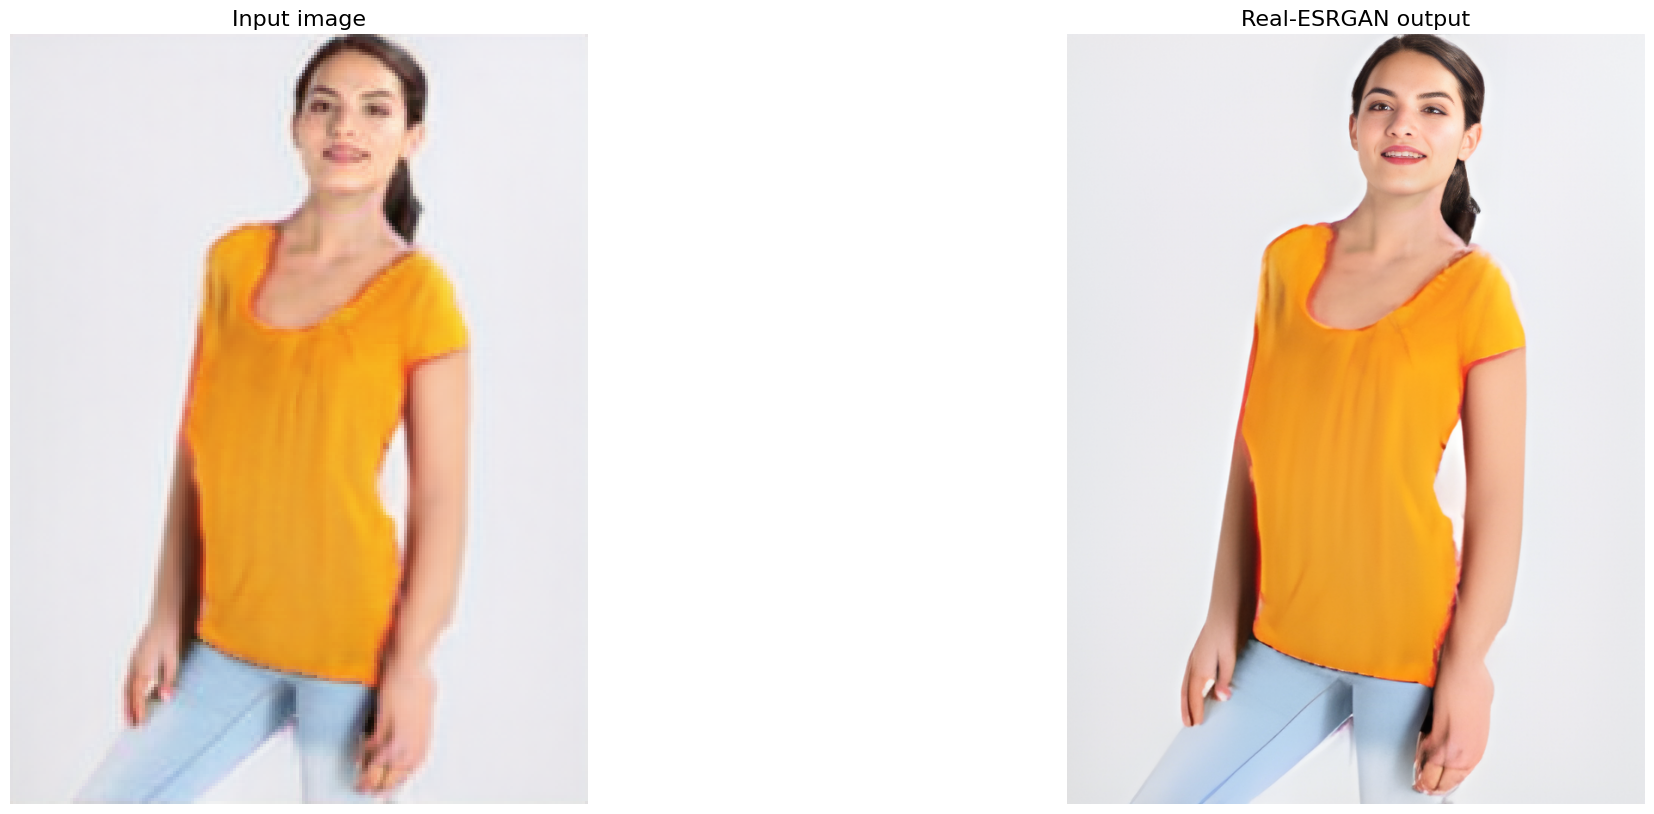

In [31]:
# utils for visualization
import cv2
import matplotlib.pyplot as plt
def display(img1, img2):
  fig = plt.figure(figsize=(25, 10))
  ax1 = fig.add_subplot(1, 2, 1)
  plt.title('Input image', fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 2, 2)
  plt.title('Real-ESRGAN output', fontsize=16)
  ax2.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2)
def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

# display each image in the upload folder
import os
import glob

input_folder = 'upload'
result_folder = 'results'
input_list = sorted(glob.glob(os.path.join(input_folder, '*')))
output_list = sorted(glob.glob(os.path.join(result_folder, '*')))
for input_path, output_path in zip(input_list, output_list):
  img_input = imread(input_path)
  img_output = imread(output_path)
  display(img_input, img_output)